# Redes Neurais - Grid de parâmetros em Perceptron de camada única
## Conforme transparência apresentada pelo professor segue a implementação descritiva da execução de um grid para comparar os resultados das execuções de ciclos de treinamento de um perceptron de camada única, baseado na regra Hebb, para o problema do AND e do OR Lógico com o salvamento dos resultados em arquivos .txt e .csv além da impressão da melhor configuração encontrada a partir da variação dos parâmetros Taxa de aprendização, Função de ativação e Inicializador de pesos baseado no número de ciclos executados e acurácia do treinamento.

## Bibliotecas

In [188]:
import numpy as np
import csv
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

## Datasets

In [189]:
# AND Lógico
dt_AND = np.array([[0, 0, 0],
                   [0, 1, 0],
                   [1, 0, 0],
                   [1, 1, 1]])

# OR Lógico
dt_OR = np.array([[0, 0, 0],
                  [0, 1, 1],
                  [1, 0, 1],
                  [1, 1, 1]])

## Funções de Ativação

In [190]:
def step(u):
    return 1 if u > 0 else 0

def sigmoid(u):
    return 1/(1 + np.exp(-u))

def tanh(u):
    return np.tanh(u)

def relu(u):
    return np.maximum(0, u)

def softmax(u):
    f = np.exp(u - np.max(u))
    return f / f.sum(axis=0)


## Métodos de inicialização de pesos

In [191]:
def zeros(n):
    return np.zeros(n)

def uns(n):
    return np.ones(n)
    
def aleatorios(n):
    return np.random.rand(n)

def aleatorios_uniformes(n):
    return np.random.uniform(0, 1, n)

def aleatorios_normal(n):
    return np.random.normal(0, 1, n)

## Classe Percetron

In [192]:
class Perceptron:
    def __init__(self, n_entradas, inicializador_pesos, eta, funcao, b, max_epocas, verbose=False):
        self.n_entradas = n_entradas
        self.inicializador_pesos = inicializador_pesos
        self.eta = eta
        self.funcao = funcao
        self.b = b
        self.max_epocas = max_epocas
        self.verbose = verbose
        self.w = [self.inicializador_pesos(self.n_entradas+1)]
        self.epocas = 0
        self.ciclos = 0
        self.melhor_peso = self.w[0]
        self.acuracia = 0.0
        self.erros = []
        
    def saida(self, x, w):
        return self.funcao(np.dot(x, w))

    def ajustar_peso(self, w, eta, t, y, x):
        return w + eta * (t - y) * x

    def treinar(self, x_treino, t_treino):
        x_treino = np.insert(x_treino, 0, self.b, axis=1)
        erro = True
        while erro and self.epocas < self.max_epocas:
            erros = 0
            erro = False
            print(f'\n{self.ciclos+1}º Ciclo --------------------------------------------------' if self.verbose else '', end='')
            for i in range(len(x_treino)):
                y = self.saida(x_treino[i], self.w[-1])
                if y != t_treino[i]:
                    self.w.append(self.ajustar_peso(self.w[-1], self.eta, t_treino[i], y, x_treino[i]))
                    erro = True
                    erros += self.eta * (t_treino[i] - y)
                    print(f'\nÉpoca {self.epocas+1}: entrada {i+1} - pesos ajustados: {self.w[-1]}' if self.verbose else '', end='')
                else:
                    print(f'\nÉpoca {self.epocas+1}: entrada {i+1} - pesos OK!' if self.verbose else '', end='')
                self.epocas += 1
            self.erros.append(erros)
            self.ciclos += 1
        self.melhor_peso = self.w[-1]
        if not erro:
            print('\nPesos ideais encontrados!' if self.verbose else '', end='')
        else:
            print('\nPesos ideais não encontrados!' if self.verbose else '', end='')
    
    def testar(self, x_teste, t_teste):
        y_predito = []
        x_teste = np.insert(x_teste, 0, self.b, axis=1)
        for i in range(len(x_teste)):
            y = self.saida(x_teste[i], self.w[-1])
            print(f'\nEntrada {i+1}: classe {y} - Esperado: classe {t_teste[i]}' if self.verbose else '', end='')
            y_predito.append(y)
        print('\n' if self.verbose else '', end='')
        self.acuracia = self.avaliar(y_predito, t_teste)
        
        return self.acuracia

    # Acurácia
    def avaliar(self, y_predito, t_teste):
        acertos = 0
        for i in range(len(y_predito)):
            if y_predito[i] == t_teste[i]:
                acertos += 1
        return float(acertos) / len(y_predito)

## Classe para busca em grid das métricas

In [193]:
# Busca em grid para otimização com diferentes métricas
class GridSearch:
    def __init__(self, taxa_aprendizado, inicializador_pesos, funcao_ativacao, n_entradas, 
                 limiar, max_epocas, dataset, cenario, verbose=False):
        self.taxa_aprendizado = taxa_aprendizado
        self.inicializador_pesos = inicializador_pesos
        self.funcao_ativacao = funcao_ativacao
        self.n_entradas = n_entradas
        self.limiar = limiar
        self.max_epocas = max_epocas
        self.nome_cenario = cenario
        self.verbose = verbose
        self.rede = []
        self.melhor_resultado = []
        self.nome_parametro = ['Número de entradas', 'Inicializador de pesos', 'Taxa de aprendizado', 
                        'Função de ativacao', 'Limiar', 'Ciclos executados', 'Épocas executadas',
                        'Melhores pesos', 'Acurácia']

        self.x_treino, self.t_treino, self.x_teste, self.t_teste = self.dividir_dataset(dataset)
        self.grid_search()
        self.n_redes = len(self.rede)
        self.__str__()
    
    # Dividir dataset em treino e teste
    def dividir_dataset(self, dataset):
        x_treino, t_treino = dataset[:, :-1], dataset[:, -1]
        x_teste, t_teste = x_treino, t_treino
        return x_treino, t_treino, x_teste, t_teste

    def grid_search(self):
        for taxa in self.taxa_aprendizado:
            for inicializador in self.inicializador_pesos:
                for funcao in self.funcao_ativacao:
                    self.rede.append(Perceptron(self.n_entradas, inicializador, taxa, funcao, 
                                                self.limiar, self.max_epocas, self.verbose))
                    self.rede[-1].treinar(self.x_treino, self.t_treino)
                    self.rede[-1].testar(self.x_treino, self.t_treino)
                    self.verificar_melhor_config(self.rede[-1])

    def verificar_melhor_config(self, rede):
        if self.melhor_resultado == []:
            self.melhor_resultado.append(rede)

        condicao1 = (rede.acuracia > self.melhor_resultado[-1].acuracia and \
                     rede.ciclos <= self.melhor_resultado[-1].ciclos)
        condicao2 = (rede.ciclos < self.melhor_resultado[-1].ciclos and \
                     rede.acuracia >= self.melhor_resultado[-1].acuracia)
        condicao3 = (rede.ciclos == self.melhor_resultado[-1].ciclos and \
                     rede.acuracia == self.melhor_resultado[-1].acuracia)
        if condicao1 or condicao2:
            self.melhor_resultado = []
            self.melhor_resultado.append(rede)
        elif condicao3:
            self.melhor_resultado.append(rede)

    def salvar_resultados(self, extensao):
        # Salvar csv com os parâmetros de cada rede do grid
        if extensao == 'csv':
            f = open('grid_search_' + self.nome_cenario + '.csv', 'w', newline='', encoding='utf-8')
            arquivo = csv.writer(f)
            arquivo.writerow([self.nome_parametro[0],self.nome_parametro[1],self.nome_parametro[2],
                              self.nome_parametro[3],self.nome_parametro[4],self.nome_parametro[5],
                              self.nome_parametro[6],self.nome_parametro[7],self.nome_parametro[8]])
            for rede in self.rede:
                arquivo.writerow([rede.n_entradas,rede.inicializador_pesos.__name__,rede.eta,
                            rede.funcao.__name__,rede.b,rede.ciclos,rede.epocas,rede.melhor_peso,
                            rede.acuracia])
            f.close()
        # Salvar txt com os parâmetros de cada rede do grid
        elif extensao == 'txt':
            i = 1
            for rede in self.rede:
                if rede == self.rede[0]:
                    with open('grid_search_' + self.nome_cenario + '.txt', 'w') as arquivo:
                        arquivo.write(f'Cenário experimental: {self.nome_cenario}\n')
                        arquivo.write(f'Número de redes configuradas: {len(self.rede)}\n')
                        arquivo.write('\n' + '~'*42 + '\n')
                        arquivo.write('  Parâmetros selecionados para a ' + str(i) +'ª rede\n')
                        arquivo.write('~'*42 + '\n')
                        arquivo.write(f'{self.nome_parametro[0]:24}: {rede.n_entradas}\n')
                        arquivo.write(f'{self.nome_parametro[1]:24}: {rede.inicializador_pesos.__name__}\n')
                        arquivo.write(f'{self.nome_parametro[2]:24}: {rede.eta}\n')
                        arquivo.write(f'{self.nome_parametro[3]:24}: {rede.funcao.__name__}\n')
                        arquivo.write(f'{self.nome_parametro[4]:24}: {rede.b}\n')
                        arquivo.write(f'{self.nome_parametro[5]:24}: {rede.ciclos}\n')
                        arquivo.write(f'{self.nome_parametro[6]:24}: {rede.epocas}\n')
                        arquivo.write(f'{self.nome_parametro[7]:24}: {rede.melhor_peso}\n')
                        arquivo.write(f'{self.nome_parametro[8]:24}: {rede.acuracia*100:.2f}%\n\n')
                else:
                    arquivo = open('grid_search_' + self.nome_cenario + '.txt', 'r')
                    conteudo = arquivo.readlines()
                    conteudo.append('~'*42 + '\n')
                    conteudo.append('  Parâmetros selecionados para a ' + str(i) +'ª rede\n')
                    conteudo.append('~'*42 + '\n')
                    conteudo.append(f'{self.nome_parametro[0]:24}: {rede.n_entradas}\n')
                    conteudo.append(f'{self.nome_parametro[1]:24}: {rede.inicializador_pesos.__name__}\n')
                    conteudo.append(f'{self.nome_parametro[2]:24}: {rede.eta}\n')
                    conteudo.append(f'{self.nome_parametro[3]:24}: {rede.funcao.__name__}\n')
                    conteudo.append(f'{self.nome_parametro[4]:24}: {rede.b}\n')
                    conteudo.append(f'{self.nome_parametro[5]:24}: {rede.ciclos}\n')
                    conteudo.append(f'{self.nome_parametro[6]:24}: {rede.epocas}\n')
                    conteudo.append(f'{self.nome_parametro[7]:24}: {rede.melhor_peso}\n')
                    conteudo.append(f'{self.nome_parametro[8]:24}: {rede.acuracia*100:.2f}%\n\n')
                    arquivo = open('grid_search_' + self.nome_cenario + '.txt', 'w')
                    arquivo.writelines(conteudo)   
                    arquivo.close()
                i += 1
        else:
            print('Extensão inválida')

    def __str__(self):
        print(f'Foram criadas {self.n_redes} redes')
        print(f'\nMELHOR(ES) CONFIGURAÇÃO(ÕES) ENCONTRADA(S)')
        for melhor_resultado in self.melhor_resultado:
            print(f'\n{  self.nome_parametro[0]:26}: {melhor_resultado.n_entradas}')
            print(f'{  self.nome_parametro[1]:26}: {melhor_resultado.inicializador_pesos.__name__}')
            print(f'{  self.nome_parametro[2]:26}: {melhor_resultado.eta}')
            print(f'{  self.nome_parametro[3]:26}: {melhor_resultado.funcao.__name__}')
            print(f'{  self.nome_parametro[4]:26}: {melhor_resultado.b}')
            print(f'{  self.nome_parametro[5]:26}: {melhor_resultado.ciclos}')
            print(f'{  self.nome_parametro[6]:26}: {melhor_resultado.epocas}')
            print(f'{  self.nome_parametro[7]:26}: {melhor_resultado.melhor_peso}')
            print(f'{  self.nome_parametro[8]:26}: {melhor_resultado.acuracia*100:.2f}%')

## Método para visualização dos resultados

In [194]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel ('ERROR')

# Definindo área de plotagem
def plot_resultados(X, t, classificador, nome_rede, nome_dataset, resolucao=0.02):
    # Subplot
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    fig.suptitle(f'{nome_rede} - {nome_dataset}')

    # Primeiro gráfico
    ax[0].set_title(f'Classificação das amostras')
    ax[0].set_xlabel('$x_1$')
    ax[0].set_ylabel('$x_2$')

    markers = ['s', 'x', 'o', '^', 'v']
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cyan']
    cmap = ListedColormap(colors[:len(np.unique(t))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolucao), np.arange(x2_min, x2_max, resolucao))

    xx = np.array([xx1.ravel(), xx2.ravel()]).T
    xx = np.insert(xx, 0, classificador.b, axis=1)

    Z = np.array([classificador.saida(xx[i], classificador.melhor_peso) for i in range(len(xx))])
    Z = Z.reshape(xx1.shape)
    ax[0].contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)

    for i, classe in enumerate(np.unique(t)):
        ax[0].scatter(x=X[t == classe, 0], y=X[t == classe, 1], alpha=0.8, c=cmap(i),
                    marker=markers[i], label=classe)

    # Segundo gráfico
    erros = np.abs(classificador.erros)
    ax[1].plot(range(1, len(erros) + 1), erros, marker='o')
    ax[1].set_title(f'Minimização do erro por épocas')
    ax[1].set_xlabel('Época')
    ax[1].set_ylabel('Erro')

    plt.show() 

## Parâmetros

In [195]:
taxa_aprendizado = [0.5, 0.1, 0.001, 0.2, 0.9]
inicializador_pesos = [zeros, uns, aleatorios, aleatorios_uniformes, aleatorios_normal]
funcao_ativacao = [step, sigmoid, tanh, relu, softmax]

n_entradas = 2 # Tanto para AND quanto para OR temos 2 entradas
limiar = 1
max_epocas = 1200 # Caso o não encontre o peso ideal, o treino será realizado até máximo de épocas

## Testando as classes diretamente com um conjunto de parâmetros

In [196]:
x_treino, t_treino = dt_AND[:, :-1], dt_AND[:, -1]
x_teste, t_teste = x_treino, t_treino

rede = Perceptron(n_entradas, inicializador_pesos[0], taxa_aprendizado[0], 
                  funcao_ativacao[0], limiar, max_epocas, verbose=True)
rede.treinar(x_treino, t_treino)
acuracia = rede.testar(x_teste, t_teste)
print('Acurácia de teste de {:.2f}%'.format(acuracia * 100))

nome_parametro = ['Número de entradas', 'Inicializador de pesos', 'Taxa de aprendizado', 
                  'Função de ativacao', 'Limiar', 'Ciclos executados', 'Épocas executadas',
                  'Melhores pesos', 'Acurácia']

with open('grid_search_TESTE.txt', 'w') as arquivo:
    arquivo.write('~'*40 + '\n')
    arquivo.write('  Parâmetros selecionados para o TESTE\n')
    arquivo.write('~'*40 + '\n')
    arquivo.write(f'{nome_parametro[0]:24}: {rede.n_entradas}\n')
    arquivo.write(f'{nome_parametro[1]:24}: {rede.inicializador_pesos.__name__}\n')
    arquivo.write(f'{nome_parametro[2]:24}: {rede.eta}\n')
    arquivo.write(f'{nome_parametro[3]:24}: {rede.funcao.__name__}\n')
    arquivo.write(f'{nome_parametro[4]:24}: {rede.b}\n')
    arquivo.write(f'{nome_parametro[5]:24}: {rede.ciclos}\n')
    arquivo.write(f'{nome_parametro[6]:24}: {rede.epocas}\n')
    arquivo.write(f'{nome_parametro[7]:24}: {rede.melhor_peso}\n')
    arquivo.write(f'{nome_parametro[8]:24}: {rede.acuracia*100:.2f}%\n')


1º Ciclo --------------------------------------------------
Época 1: entrada 1 - pesos OK!
Época 2: entrada 2 - pesos OK!
Época 3: entrada 3 - pesos OK!
Época 4: entrada 4 - pesos ajustados: [0.5 0.5 0.5]
2º Ciclo --------------------------------------------------
Época 5: entrada 1 - pesos ajustados: [0.  0.5 0.5]
Época 6: entrada 2 - pesos ajustados: [-0.5  0.5  0. ]
Época 7: entrada 3 - pesos OK!
Época 8: entrada 4 - pesos ajustados: [0.  1.  0.5]
3º Ciclo --------------------------------------------------
Época 9: entrada 1 - pesos OK!
Época 10: entrada 2 - pesos ajustados: [-0.5  1.   0. ]
Época 11: entrada 3 - pesos ajustados: [-1.   0.5  0. ]
Época 12: entrada 4 - pesos ajustados: [-0.5  1.   0.5]
4º Ciclo --------------------------------------------------
Época 13: entrada 1 - pesos OK!
Época 14: entrada 2 - pesos OK!
Época 15: entrada 3 - pesos ajustados: [-1.   0.5  0.5]
Época 16: entrada 4 - pesos ajustados: [-0.5  1.   1. ]
5º Ciclo ----------------------------------------

## 1ª Caso - AND

In [197]:
redes_AND = GridSearch(taxa_aprendizado, inicializador_pesos, funcao_ativacao, n_entradas,
                   limiar, max_epocas, dt_AND, 'AND')
redes_AND.salvar_resultados('txt')
redes_AND.salvar_resultados('csv')

Foram criadas 125 redes

MELHOR(ES) CONFIGURAÇÃO(ÕES) ENCONTRADA(S)

Número de entradas        : 2
Inicializador de pesos    : uns
Taxa de aprendizado       : 0.5
Função de ativacao        : step
Limiar                    : 1
Ciclos executados         : 2
Épocas executadas         : 8
Melhores pesos            : [-0.5  0.5  0.5]
Acurácia                  : 100.00%

Número de entradas        : 2
Inicializador de pesos    : aleatorios
Taxa de aprendizado       : 0.9
Função de ativacao        : step
Limiar                    : 1
Ciclos executados         : 2
Épocas executadas         : 8
Melhores pesos            : [-0.522408    0.32808689  0.48249602]
Acurácia                  : 100.00%


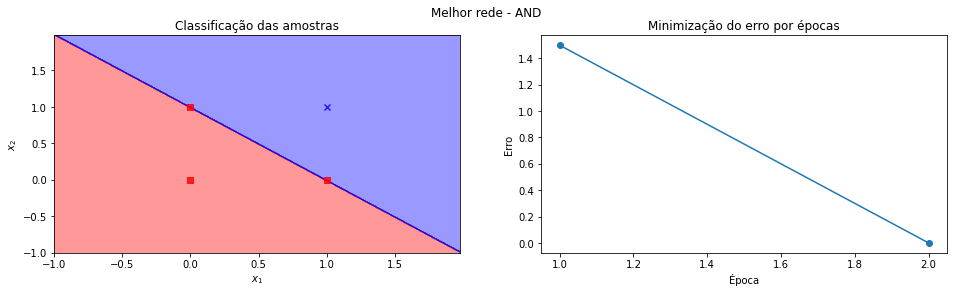

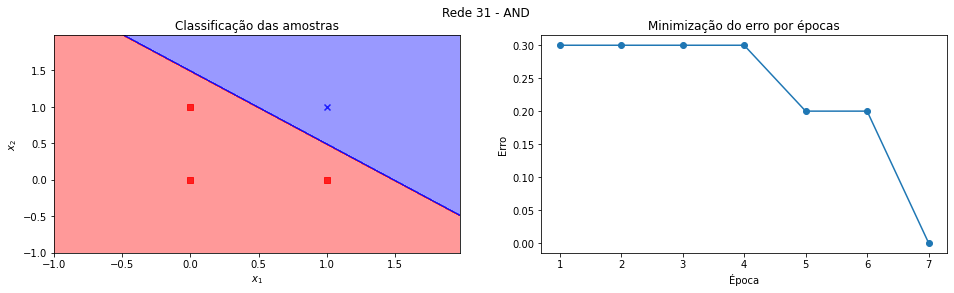

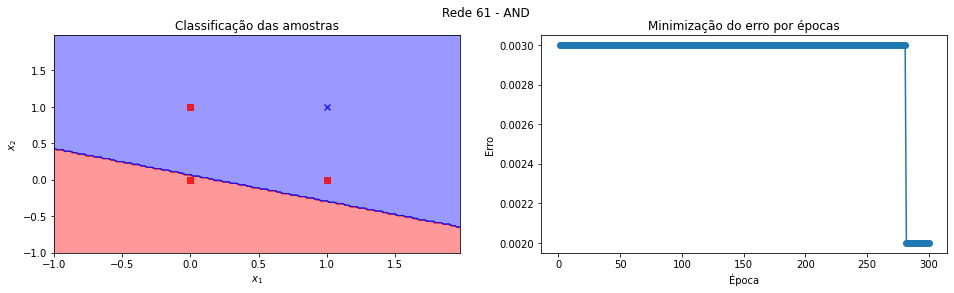

In [201]:
X, t = dt_AND[:, :-1], dt_AND[:, -1]
nome_rede = ['Melhor rede', 'Rede 31', 'Rede 61']
classificador = [redes_AND.melhor_resultado[0], redes_AND.rede[30], redes_AND.rede[60]]

for i in range(len(classificador)):
    plot_resultados(X, t, classificador[i], nome_rede[i], nome_dataset='AND')

## 2ª Caso - OR

In [199]:
redes_OR = GridSearch(taxa_aprendizado, inicializador_pesos, funcao_ativacao, n_entradas,
                   limiar, max_epocas, dt_OR, 'OR')
redes_OR.salvar_resultados('txt')
redes_OR.salvar_resultados('csv')

Foram criadas 125 redes

MELHOR(ES) CONFIGURAÇÃO(ÕES) ENCONTRADA(S)

Número de entradas        : 2
Inicializador de pesos    : aleatorios_normal
Taxa de aprendizado       : 0.1
Função de ativacao        : step
Limiar                    : 1
Ciclos executados         : 1
Épocas executadas         : 4
Melhores pesos            : [-0.50819028  1.25082683  1.05863065]
Acurácia                  : 100.00%


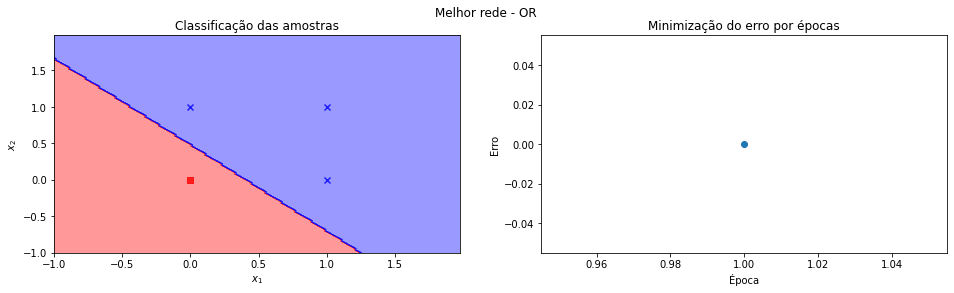

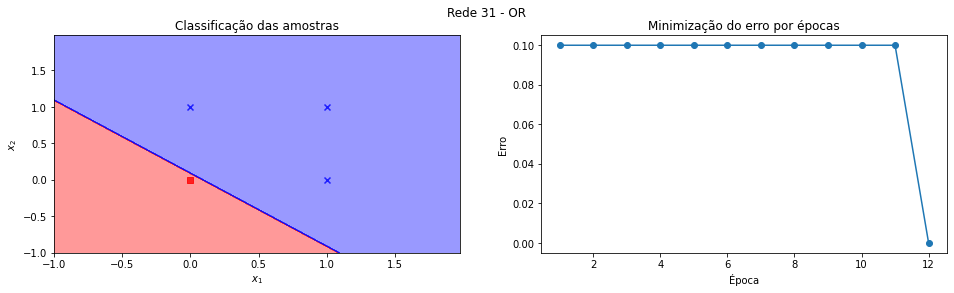

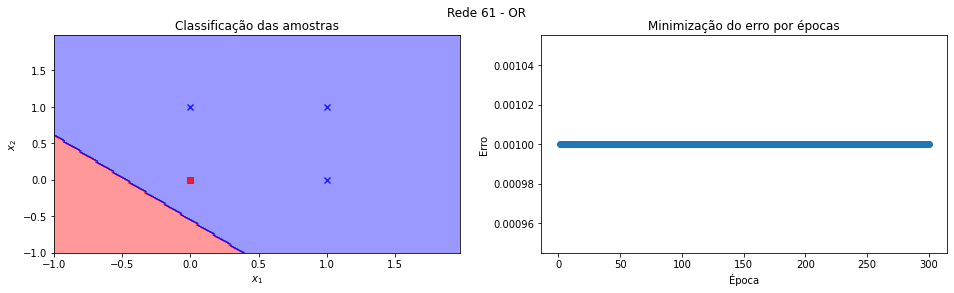

In [215]:
X, t = dt_OR[:, :-1], dt_OR[:, -1]
nome_rede = ['Melhor rede', 'Rede 31', 'Rede 61']
classificador = [redes_OR.melhor_resultado[0], redes_OR.rede[30], redes_OR.rede[60]]

for i in range(len(classificador)):
    plot_resultados(X, t, classificador[i], nome_rede[i], nome_dataset='OR')